# PREPROCESSING

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def load_and_preprocess(filepath, n_lags=5):
    df = pd.read_csv(filepath)  # ✅ don't use parse_dates here
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')  # ✅ correct parsing

    df = df.sort_values('Timestamp')
    df = df[['Timestamp', 'Close']]  # we'll use just Timestamp + Close

    # Create lag features
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)]

    # Normalize features + target
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[feature_cols + ['Close']] = scaler.fit_transform(df_scaled[feature_cols + ['Close']])

    X = df_scaled[feature_cols].values
    y = df_scaled['Close'].values
    timestamps = df_scaled['Timestamp'].values  # ✅ this was missing before

    return X, y, df_scaled, scaler, timestamps


# MODELS

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def reshape_for_lstm(X):
    return np.reshape(X, (X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)


def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


def train_lstm(X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    X_train_lstm = reshape_for_lstm(X_train)
    X_val_lstm = reshape_for_lstm(X_val)

    model = build_lstm(input_shape=(X_train.shape[1], 1))
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val),
              epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])
    return model


def predict_lstm(model, X_test):
    X_test_lstm = reshape_for_lstm(X_test)
    return model.predict(X_test_lstm).flatten()


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def reshape_for_gru(X):
    return np.reshape(X, (X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)


def build_gru(input_shape):
    model = Sequential()
    model.add(GRU(50, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


def train_gru(X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    X_train_gru = reshape_for_gru(X_train)
    X_val_gru = reshape_for_gru(X_val)

    model = build_gru(input_shape=(X_train.shape[1], 1))
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train_gru, y_train, validation_data=(X_val_gru, y_val),
              epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])
    return model


def predict_gru(model, X_test):
    X_test_gru = reshape_for_gru(X_test)
    return model.predict(X_test_gru).flatten()


# EVALUATE

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X_test, y_test, model_type='sklearn'):
    if model_type == 'keras':
        predictions = model.predict(X_test).flatten()
    else:
        predictions = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse, predictions

def plot_predictions(y_true, y_pred, title="Forecast vs Actual"):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# LSTM

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.7559e-06 - val_loss: 5.1512e-06
Epoch 2/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.7009e-08 - val_loss: 5.4097e-06
Epoch 3/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 4.8849e-08 - val_loss: 5.5570e-06
Epoch 4/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 4.5803e-08 - val_loss: 6.4561e-06
Epoch 5/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 4.7568e-08 - val_loss: 4.8850e-06
Epoch 6/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 4.0412e-08 - val_loss: 5.0402e-06
Epoch 7/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 4.2231e-08 - val_loss: 7.8637e-06
Epoch 8/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.4775e-08 - val_loss: 6.1354e-06
Epoch 9/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.5759e-08 - val_loss: 7.6820e-06
Epoch 10/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 3.7617e-08 - val_loss: 7.4250e-06
Epoch 11/100
1600/1600 ━━━━━━━━━━━━━

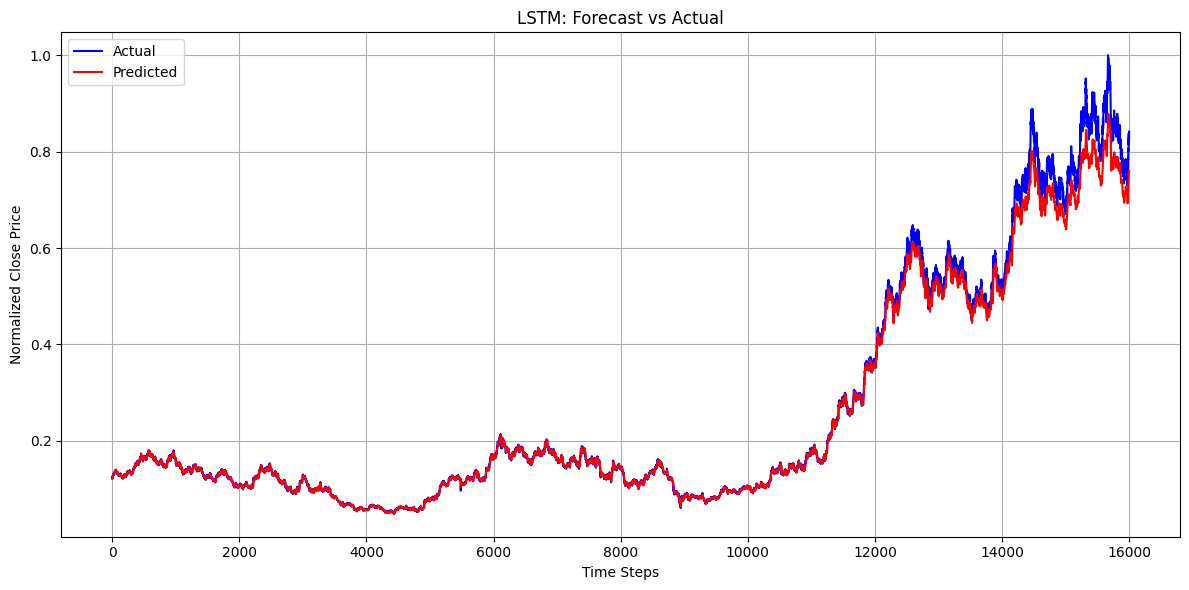

LSTM R² score: 0.9915
LSTM Accuracy: 97.7617%


In [8]:
import sys
import os
from sklearn.model_selection import train_test_split

# 1. Load and preprocess the data
file_path = '/content/sample_data/bitcoin_5min_latest (1).csv'
X, y, df, scaler, timestamps = load_and_preprocess(file_path, n_lags=5)

# 2. Split into train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

# 3. Train the LSTM model
model = train_lstm(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

# 4. Predict
predictions = predict_lstm(model, X_test)

# 5. Evaluate the model manually
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"LSTM RMSE: {rmse:.4f}")

# 6. Plot predictions
plot_predictions(y_test, predictions, title="LSTM: Forecast vs Actual")

from sklearn.metrics import r2_score

# 7. Calculate R² score
r2 = r2_score(y_test, predictions)
print(f"LSTM R² score: {r2:.4f}")

# 8. Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - predictions) / y_test)*100)
accuracy = 100 - mape
print(f"LSTM Accuracy: {accuracy:.4f}%")



# GRU

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 4.0299e-06 - val_loss: 6.2122e-06
Epoch 2/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.0134e-07 - val_loss: 6.7938e-06
Epoch 3/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 6.8758e-08 - val_loss: 7.0755e-06
Epoch 4/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 6.8849e-08 - val_loss: 6.5876e-06
Epoch 5/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 6.2273e-08 - val_loss: 7.0026e-06
Epoch 6/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5.4470e-08 - val_loss: 7.9415e-06
Epoch 7/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5.8083e-08 - val_loss: 7.7652e-06
Epoch 8/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 5.0206e-08 - val_loss: 6.5696e-06
Epoch 9/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 5.0242e-08 - val_loss: 6.4691e-06
Epoch 10/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 4.9788e-08 - val_loss: 7.2172e-06
Epoch 11/100
1600/1600 

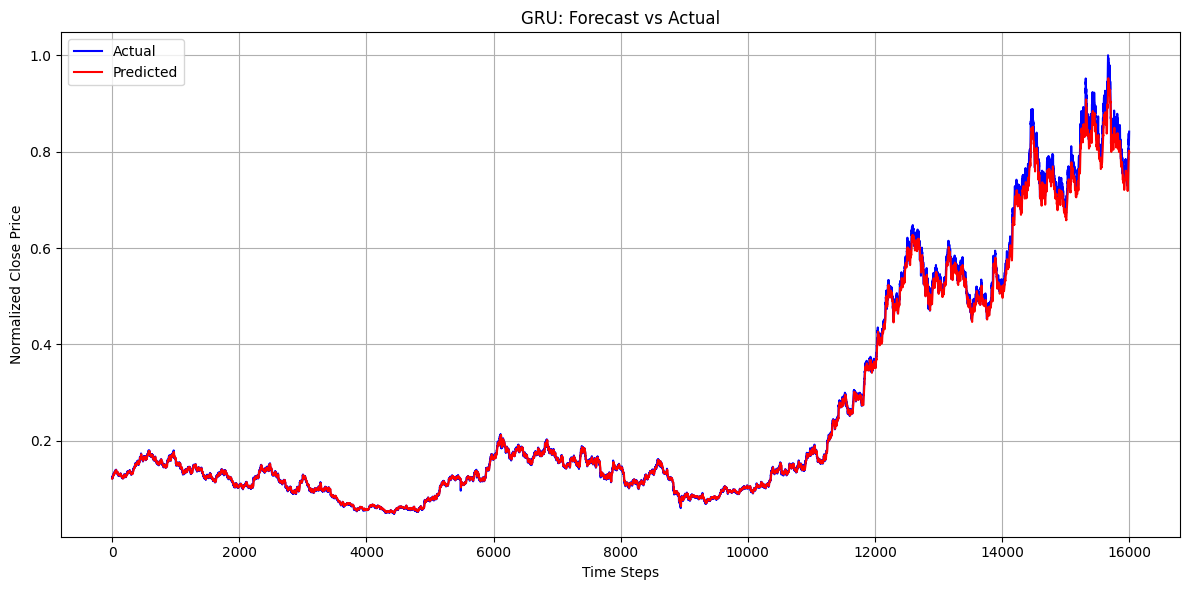

GRU R² score: 0.9981
GRU Accuracy: 98.2661%


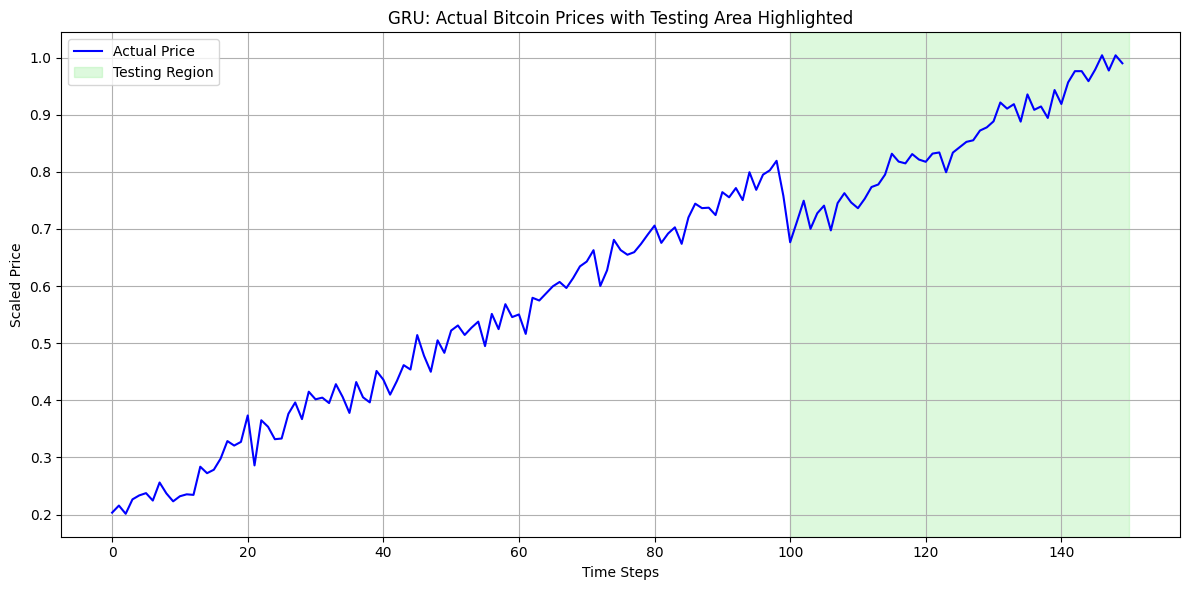

In [9]:
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Load and preprocess the data
file_path = '/content/sample_data/bitcoin_5min_latest (1).csv'
X, y, df, scaler, timestamps = load_and_preprocess(file_path, n_lags=5)

# 2. Split into train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

# 3. Train the GRU model
model = train_gru(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

# 4. Predict
predictions = predict_gru(model, X_test)

# 5. Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"GRU RMSE: {rmse:.4f}")

# 6. Plot predictions
plot_predictions(y_test, predictions, title="GRU: Forecast vs Actual")


from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 7. Calculate R² score
r2 = r2_score(y_test, predictions)
print(f"GRU R² score: {r2:.4f}")

# 8. Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - predictions) / y_test)*100)
accuracy = 100 - mape
print(f"GRU Accuracy: {accuracy:.4f}%")


import matplotlib.pyplot as plt
import numpy as np

# Example synthetic data (replace with actual if needed)
train_actual = np.linspace(0.2, 0.8, 100) + np.random.normal(0, 0.02, 100)
test_actual = np.linspace(0.7, 1.0, 50) + np.random.normal(0, 0.02, 50)

train_steps = np.arange(len(train_actual))
test_steps = np.arange(len(train_actual), len(train_actual) + len(test_actual))

# Combine data
total_steps = np.concatenate([train_steps, test_steps])
total_actual = np.concatenate([train_actual, test_actual])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(total_steps, total_actual, label='Actual Price', color='blue')

# Highlight only testing region
plt.axvspan(len(train_actual), len(total_steps), color='lightgreen', alpha=0.3, label='Testing Region')

plt.title('GRU: Actual Bitcoin Prices with Testing Area Highlighted')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
